# Covolutional Neural Network

In [2]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
import tqdm

## 0. Get MNIST Dataset

In [5]:
trainset = datasets.MNIST(root = './data', train = True,
                        transform = transforms.ToTensor(), download = True)

testset = datasets.MNIST(root = './data', train = False,
                       transform = transforms.ToTensor(), download=True)

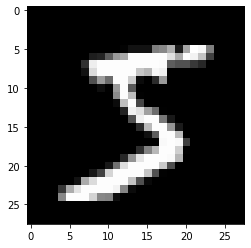

In [6]:
plt.imshow(trainset[0][0][0], cmap='gray')

## 1. What does CNN do?

In [7]:
convolution_kernel = torch.Tensor([ [1, 0, -1,], [1,0,-1], [1,0,-1] ])

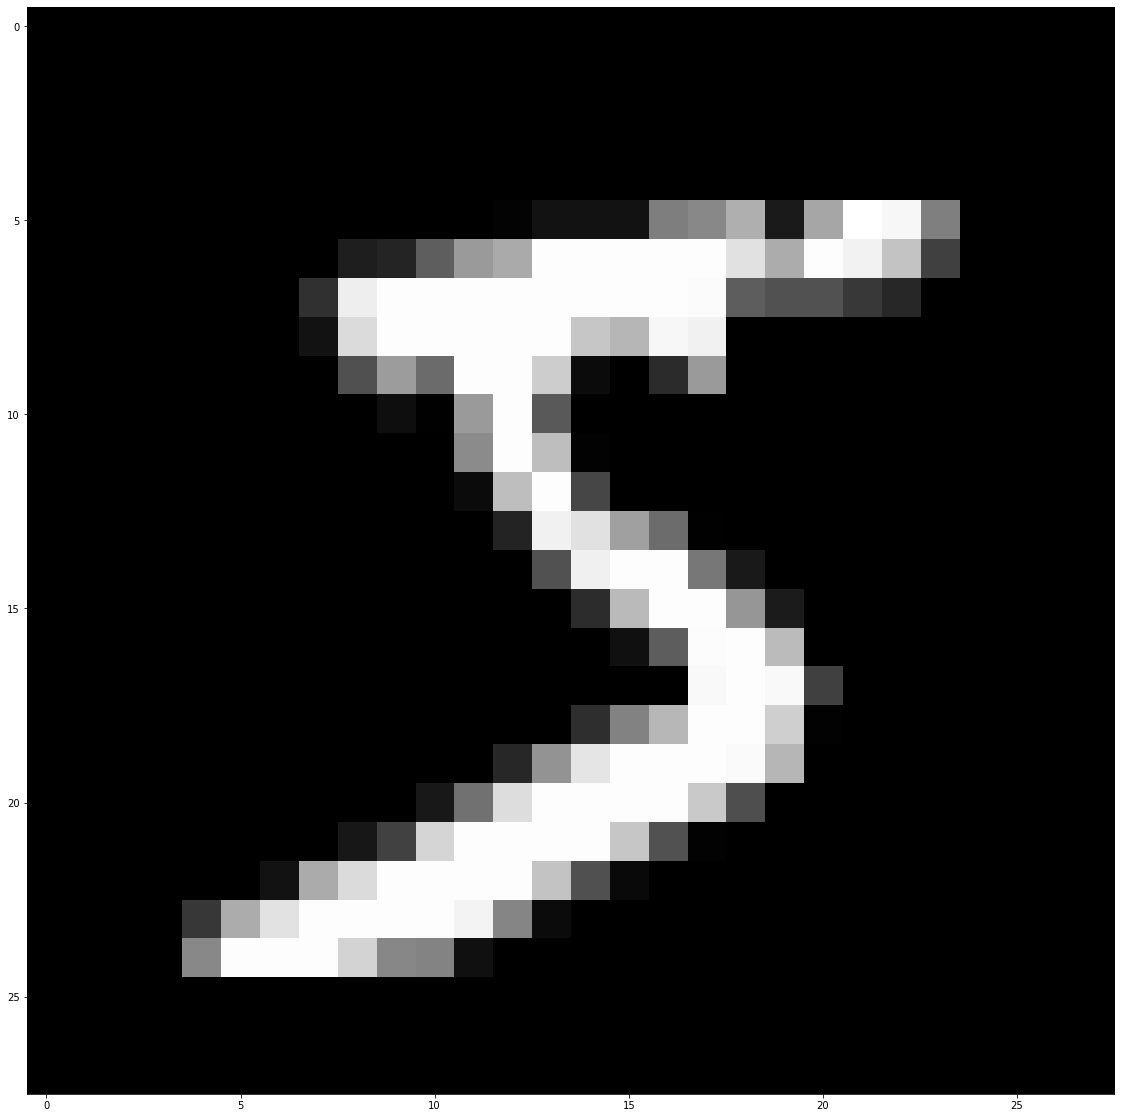

In [8]:
letter_image = trainset[0][0][0]
plt.figure(figsize=(20,20))
plt.imshow(letter_image, cmap='gray')

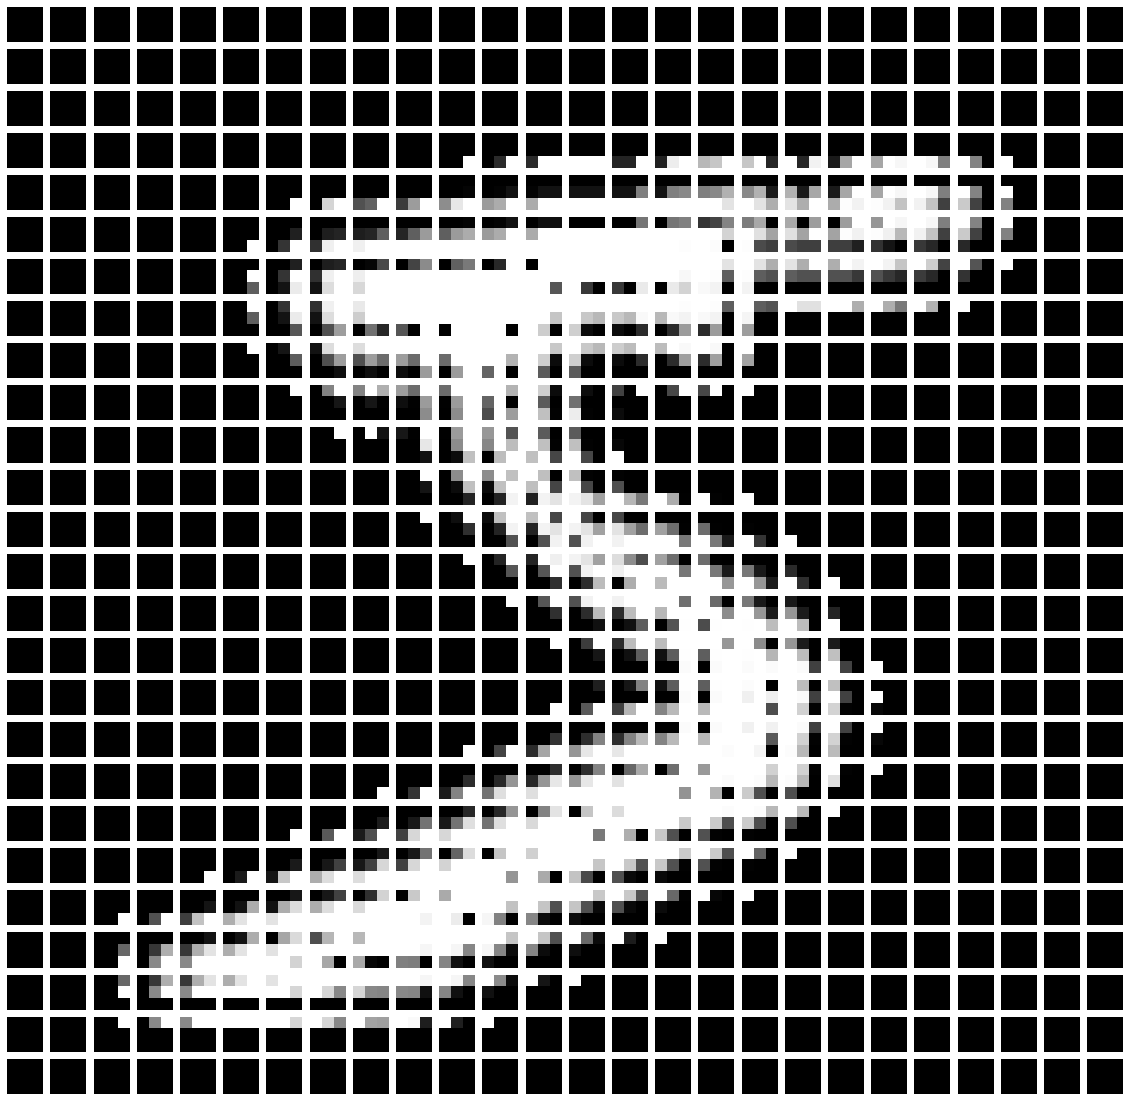

In [9]:
plt.figure(figsize=(20,20))
for i in range(1,27):
  for j in range(1,27):
    sliced_input = letter_image[i-1:i+2, j-1:j+2]
    plt.subplot(26,26,j+(i-1)*26)
    plt.imshow(sliced_input, cmap='gray')
    plt.axis('off')

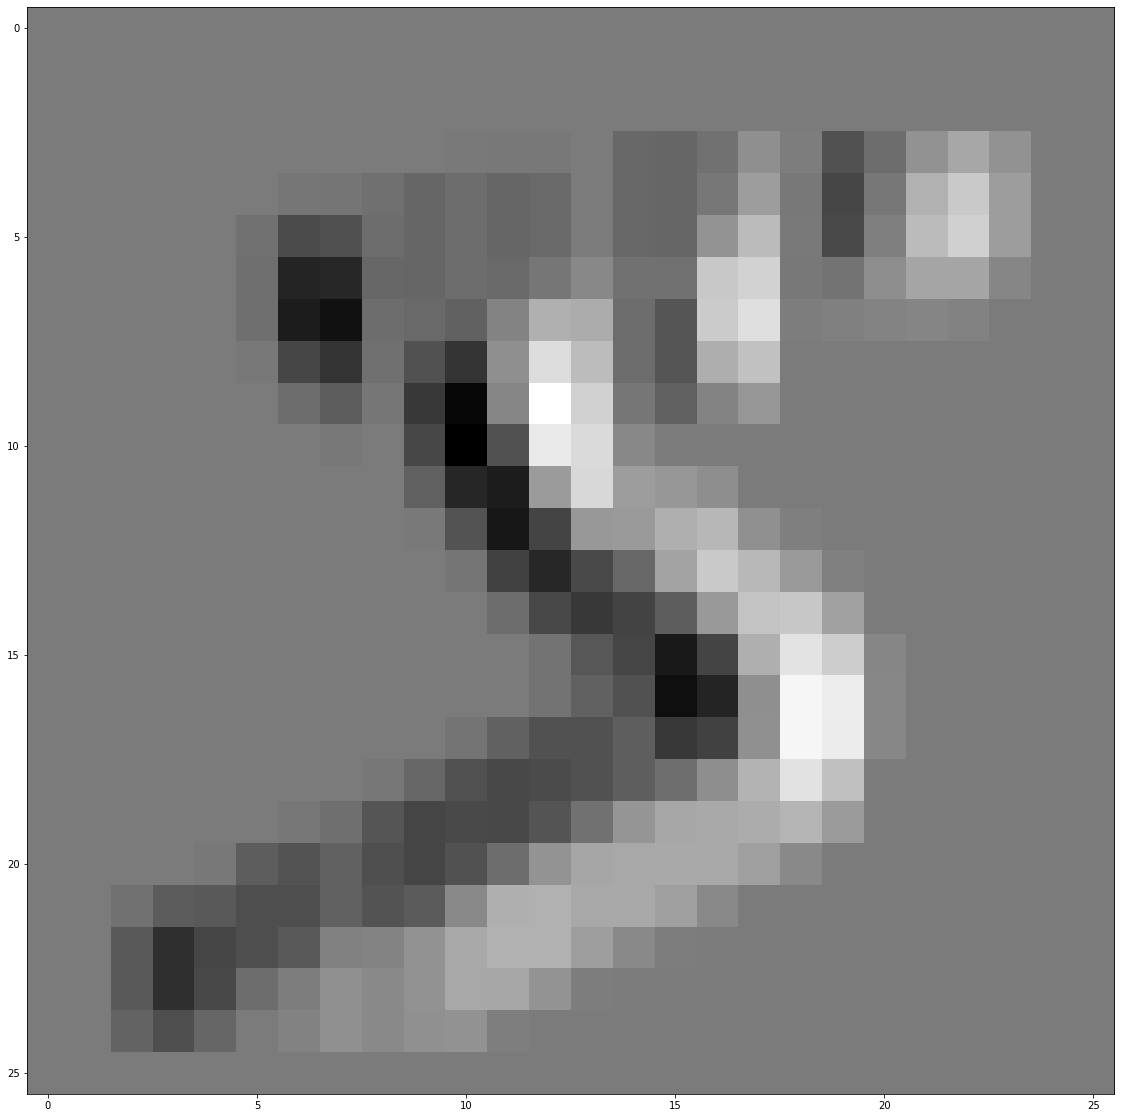

In [82]:
plt.figure(figsize=(20,20))
kernel_total_out = torch.zeros([26,26])
for i in range(1,27):
  for j in range(1,27):
    sliced_input = letter_image[i-1:i+2, j-1:j+2]
    kernel_output = (convolution_kernel *sliced_input).sum()
    kernel_total_out[i-1,j-1] = kernel_output
plt.imshow(kernel_total_out, cmap='gray')

## 2. How Fully Connected Layer worked

In [83]:
train_loader = DataLoader(trainset, batch_size=256, shuffle=True, pin_memory=True)
valid_loader = DataLoader(testset, batch_size=512, shuffle=False)

In [132]:
class FCNClassifier(nn.Module):
  def __init__(self, hidden_size):
    super().__init__()
    self.layers = nn.Sequential(
          nn.Linear(784, hidden_size),
          nn.ReLU(),
          nn.Linear(hidden_size,hidden_size),
          nn.ReLU(),
          nn.Linear(hidden_size,10)
    )
  def forward(self, x):
    return self.layers(x.view(-1,784))
  


In [133]:
def train_loop(model, optimizer, train_loader, valid_loader, loss_func, acc_func, num_epochs, device):
  model = model.to(device)
  model.train()
  
  loss_record = {'train_loss':[], 'valid_acc':[]}
  for epoch in tqdm.tqdm(range(num_epochs)):
    for batch in train_loader:
      img, label = batch
      pred = model(img.to(device))
      log_softmax_pred = torch.log(torch.softmax(pred, dim=-1)+1e-6)
      loss = loss_func(log_softmax_pred, label.to(device))
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()
      loss_record['train_loss'].append(loss.item())
    with torch.no_grad():
      model.eval()
      val_acc = 0
      for batch in valid_loader:
        img, label = batch
        pred = model(img.to(device))
        acc = acc_func(pred, label.to(device))
        val_acc += acc * len(img)
      loss_record['valid_acc'].append(val_acc/len(valid_loader.dataset))
      model.train()
  return loss_record 

def get_accuracy(pred, target):
  pred_class = torch.argmax(pred, dim=-1)
  return (pred_class==target).float().mean().item()

model = FCNClassifier(hidden_size=64)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_func = torch.nn.NLLLoss()


train_result = train_loop(model, optimizer, train_loader, valid_loader, loss_func,get_accuracy, 10, 'cuda')

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:43<00:00,  4.35s/it]


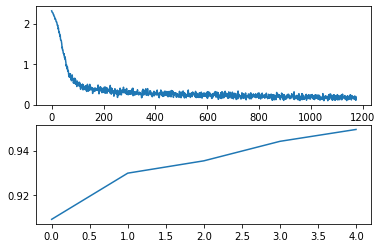

In [103]:
plt.subplot(2,1,1)
plt.plot(train_result['train_loss'])
plt.subplot(2,1,2)
plt.plot(train_result['valid_acc'])

In [93]:
batch = next(iter(train_loader))
img, label = batch
pred = model(img.to('cuda'))

### 2.1 Visualizing FCN weights

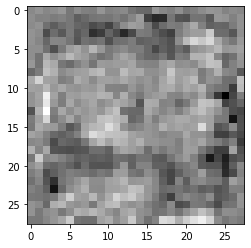

In [135]:
model = model.to('cpu')
selected_neuron_id = 4
selected_weight = model.layers[0].weight[selected_neuron_id].detach()



plt.imshow(selected_weight.view(28,28), cmap='gray')


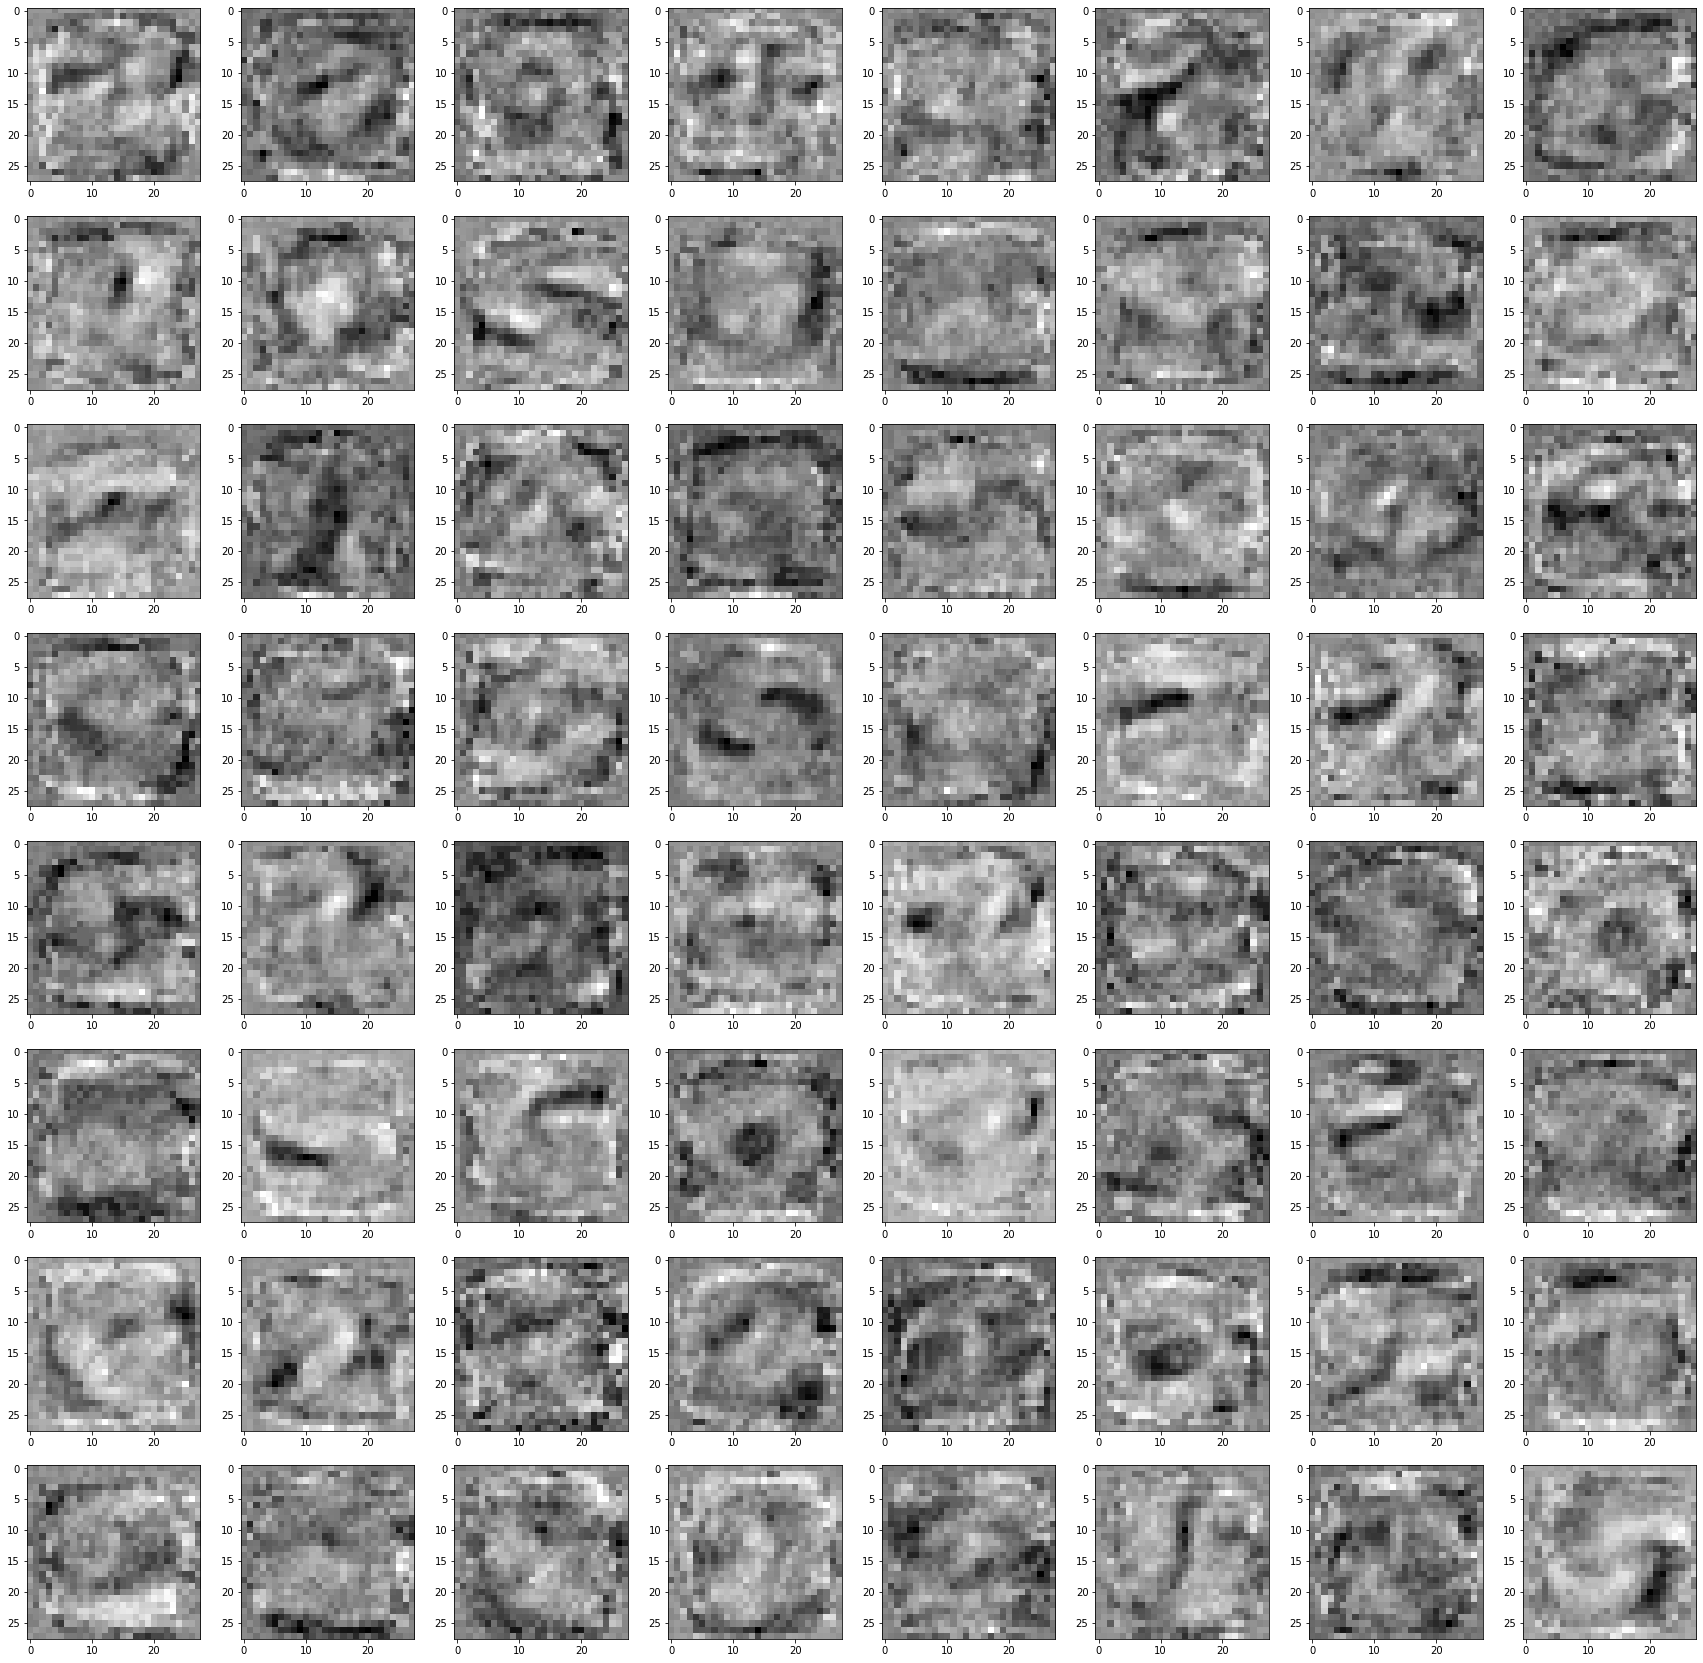

In [137]:
plt.figure(figsize=(30,30))
for i in range(8):
  for j in range(8):
    cur_id = i*8+j
    selected_weight = model.layers[0].weight[cur_id].detach().view(28,28)
    plt.subplot(8,8,cur_id+1)
    plt.imshow(selected_weight, cmap='gray')

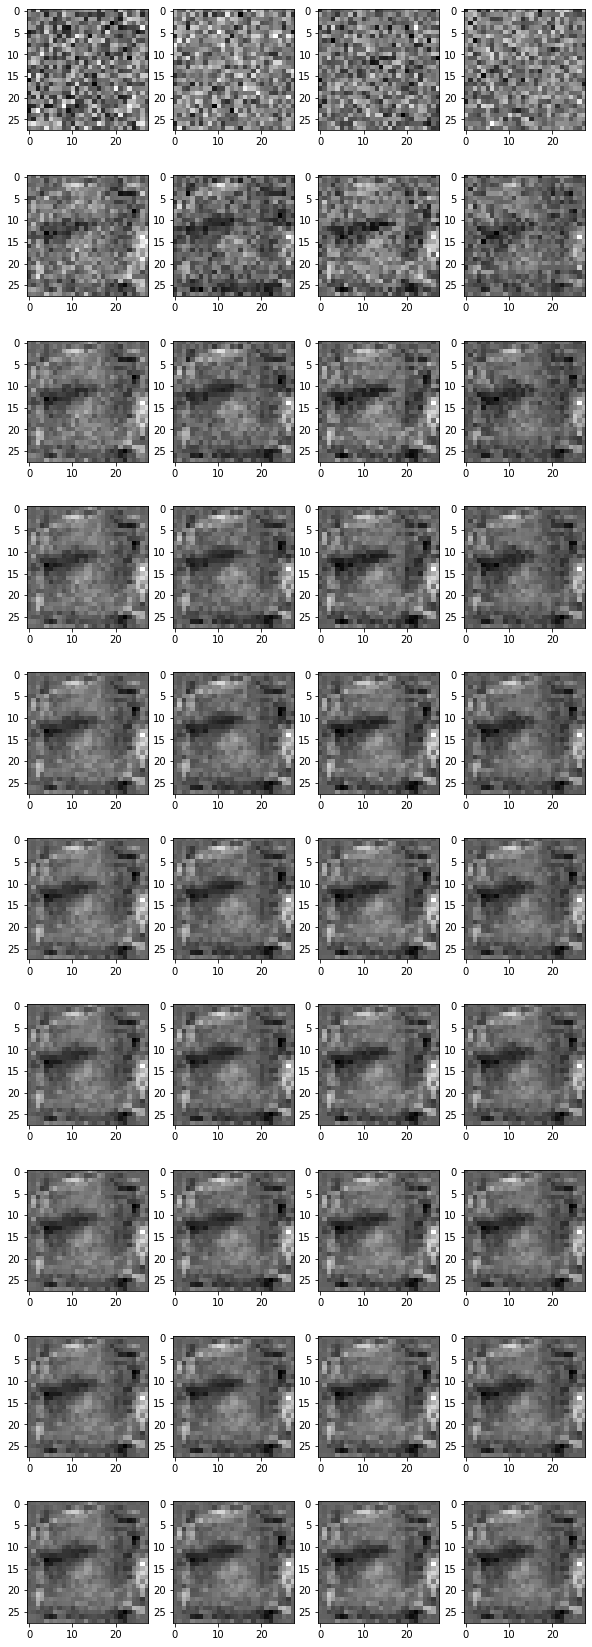

In [200]:
def freeze_model(model):
  for param in model.parameters():
    param.requires_grad = False

def unfreeze_model(model):
  for param in model.parameters():
    param.requires_grad = True

freeze_model(model)
dummy_input = torch.randn(784*4)
dummy_input = dummy_input.view(4,784)
dummy_input.requires_grad=True

selected_mid_neuron_id = 2
plt.figure(figsize=(10,30))
dummy_optimizer = torch.optim.SGD([dummy_input], lr=1)
for i in range(200):
  mid_output = model.layers(dummy_input)
  loss = -mid_output[:,selected_mid_neuron_id].mean()
  loss.backward()
#   dummy_input.data -= dummy_input.grad * 0.03
  dummy_optimizer.step()
  dummy_optimizer.zero_grad()
  if i % 20 == 0:
    for j in range(4):
      plt.subplot(10, 4, (i//20)*4+1+j)
      plt.imshow(torch.Tensor(dummy_input[j]).detach().view(28,28), cmap='gray')

In [145]:
loss.backward()

In [186]:
dir(dummy_input)

['T',
 '__abs__',
 '__add__',
 '__and__',
 '__array__',
 '__array_priority__',
 '__array_wrap__',
 '__bool__',
 '__class__',
 '__complex__',
 '__contains__',
 '__deepcopy__',
 '__delattr__',
 '__delitem__',
 '__dict__',
 '__dir__',
 '__div__',
 '__dlpack__',
 '__dlpack_device__',
 '__doc__',
 '__eq__',
 '__float__',
 '__floordiv__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__iadd__',
 '__iand__',
 '__idiv__',
 '__ifloordiv__',
 '__ilshift__',
 '__imod__',
 '__imul__',
 '__index__',
 '__init__',
 '__init_subclass__',
 '__int__',
 '__invert__',
 '__ior__',
 '__ipow__',
 '__irshift__',
 '__isub__',
 '__iter__',
 '__itruediv__',
 '__ixor__',
 '__le__',
 '__len__',
 '__long__',
 '__lshift__',
 '__lt__',
 '__matmul__',
 '__mod__',
 '__module__',
 '__mul__',
 '__ne__',
 '__neg__',
 '__new__',
 '__nonzero__',
 '__or__',
 '__pos__',
 '__pow__',
 '__radd__',
 '__rand__',
 '__rdiv__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__reversed__',
 '

In [123]:
model.layers[0].weight[0].shape

torch.Size([784])

In [100]:
log_softmax_pred = torch.log(torch.softmax(pred, dim=-1)+1e-6)

tensor([[ 9.5367e-07, -1.3816e+01, -1.3816e+01,  ..., -1.3816e+01,
         -1.3816e+01, -1.3816e+01],
        [ 9.5367e-07, -1.3816e+01, -1.3816e+01,  ..., -1.3816e+01,
         -1.3816e+01, -1.3816e+01],
        [ 9.5367e-07, -1.3816e+01, -1.3816e+01,  ..., -1.3816e+01,
         -1.3816e+01, -1.3816e+01],
        ...,
        [ 9.5367e-07, -1.3816e+01, -1.3816e+01,  ..., -1.3816e+01,
         -1.3816e+01, -1.3816e+01],
        [ 9.5367e-07, -1.3816e+01, -1.3816e+01,  ..., -1.3816e+01,
         -1.3816e+01, -1.3816e+01],
        [ 9.5367e-07, -1.3816e+01, -1.3816e+01,  ..., -1.3816e+01,
         -1.3816e+01, -1.3816e+01]], device='cuda:0', grad_fn=<LogBackward0>)

In [ ]:
loss_func(log_softmax_pred)

## 3. Make CNN with torch

In [53]:
cnn_layer = nn.Conv2d(in_channels=1, out_channels=3, kernel_size=(3,3))

In [56]:
dummy_input = torch.randn(25).view(5,5)

In [57]:
dummy_input

tensor([[-1.7735, -0.2046, -0.1535, -0.7833, -0.0177],
        [ 0.3489,  0.2893, -0.2754, -1.4016,  0.3827],
        [-0.4865,  0.3875, -0.6479,  0.0128, -1.8287],
        [ 0.9274, -0.8546,  0.6695,  0.1136,  1.0328],
        [ 0.2794, -0.6051, -1.6486,  0.4161, -0.8496]])

In [218]:
class CNNClassifier(nn.Module):
  def __init__(self, hidden_size, kernel_size):
    super().__init__()
    self.layers = nn.Sequential(
          nn.Conv2d(in_channels=1, out_channels=hidden_size, kernel_size=kernel_size),
          nn.ReLU(),
          nn.MaxPool2d(2),
          nn.Conv2d(in_channels=hidden_size, out_channels=hidden_size, kernel_size=kernel_size),
          nn.ReLU(),
          nn.MaxPool2d(2),
    )
    self.final_layer = nn.Linear(hidden_size, 10)
  def forward(self, x):
    out = self.layers(x)
    pooled_out = nn.functional.max_pool2d(out, out.shape[2])
    return self.final_layer(pooled_out[:,:,0,0])

cnn_model = CNNClassifier(64, 5)



In [219]:
cnn_model = CNNClassifier(64, 5)
cnn_optimizer = torch.optim.Adam(cnn_model.parameters(), lr=1e-3)
loss_func = torch.nn.NLLLoss()

cnn_train_result = train_loop(cnn_model, cnn_optimizer, train_loader, valid_loader, loss_func,get_accuracy, 10, 'cuda')

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:48<00:00,  4.86s/it]


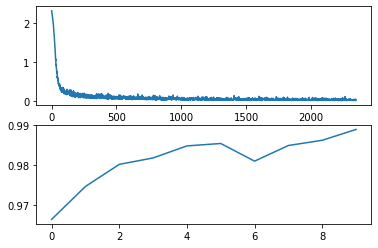

In [220]:
plt.subplot(2,1,1)
plt.plot(cnn_train_result['train_loss'])
plt.subplot(2,1,2)
plt.plot(cnn_train_result['valid_acc'])

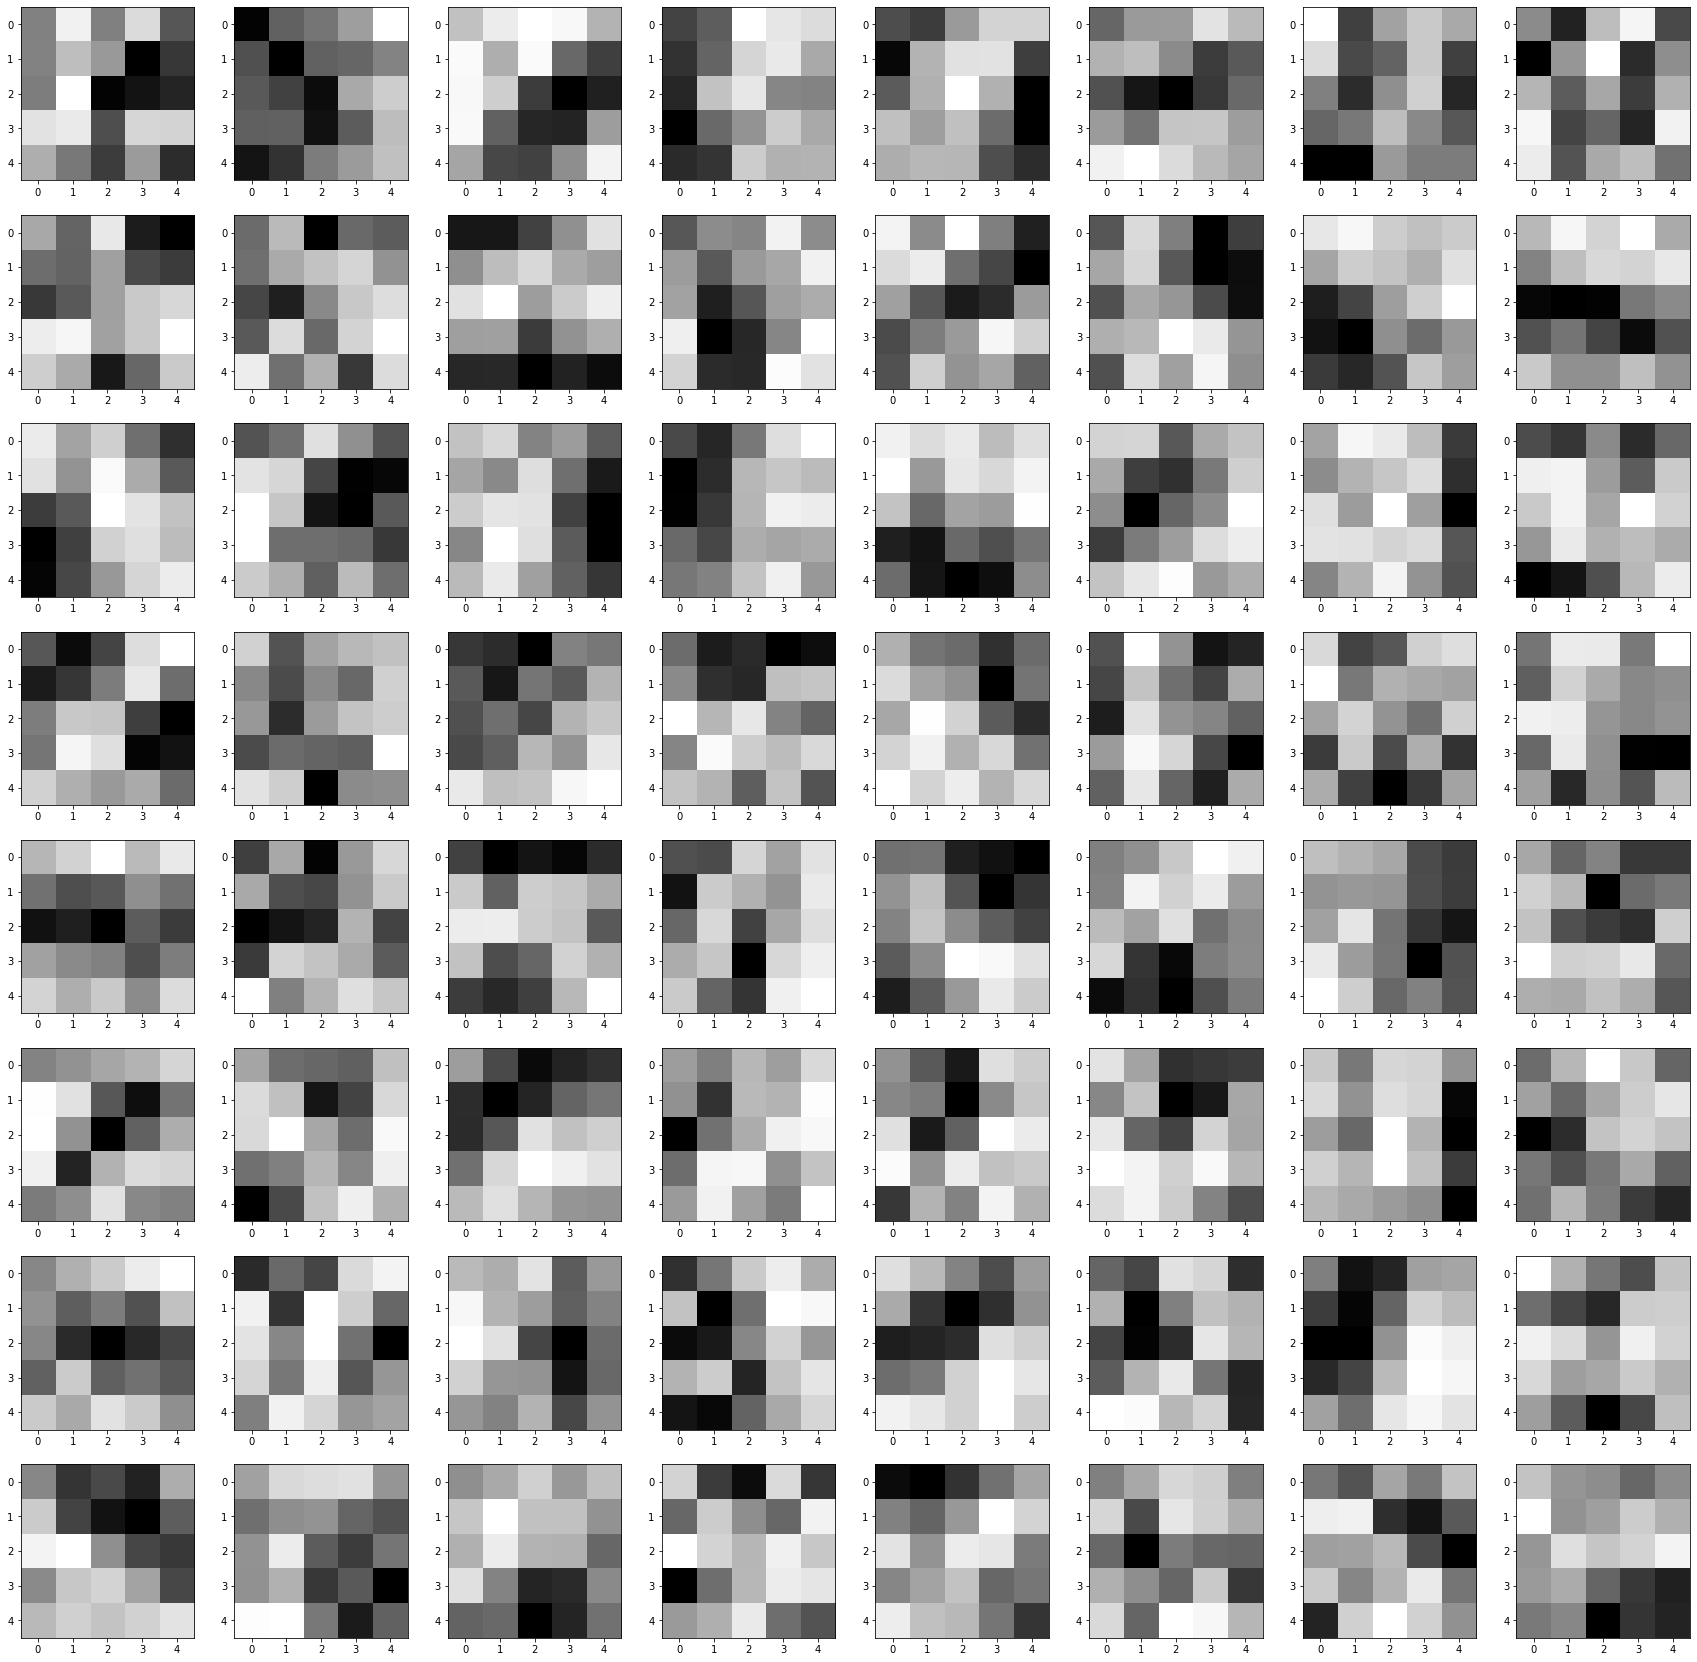

In [225]:
cnn_model = cnn_model.to('cpu')
plt.figure(figsize=(30,30))
for i in range(8):
  for j in range(8):
    cur_id = i*8+j
    selected_weight = cnn_model.layers[0].weight[cur_id].detach().view(5,5)
    plt.subplot(8,8,cur_id+1)
    plt.imshow(selected_weight, cmap='gray')

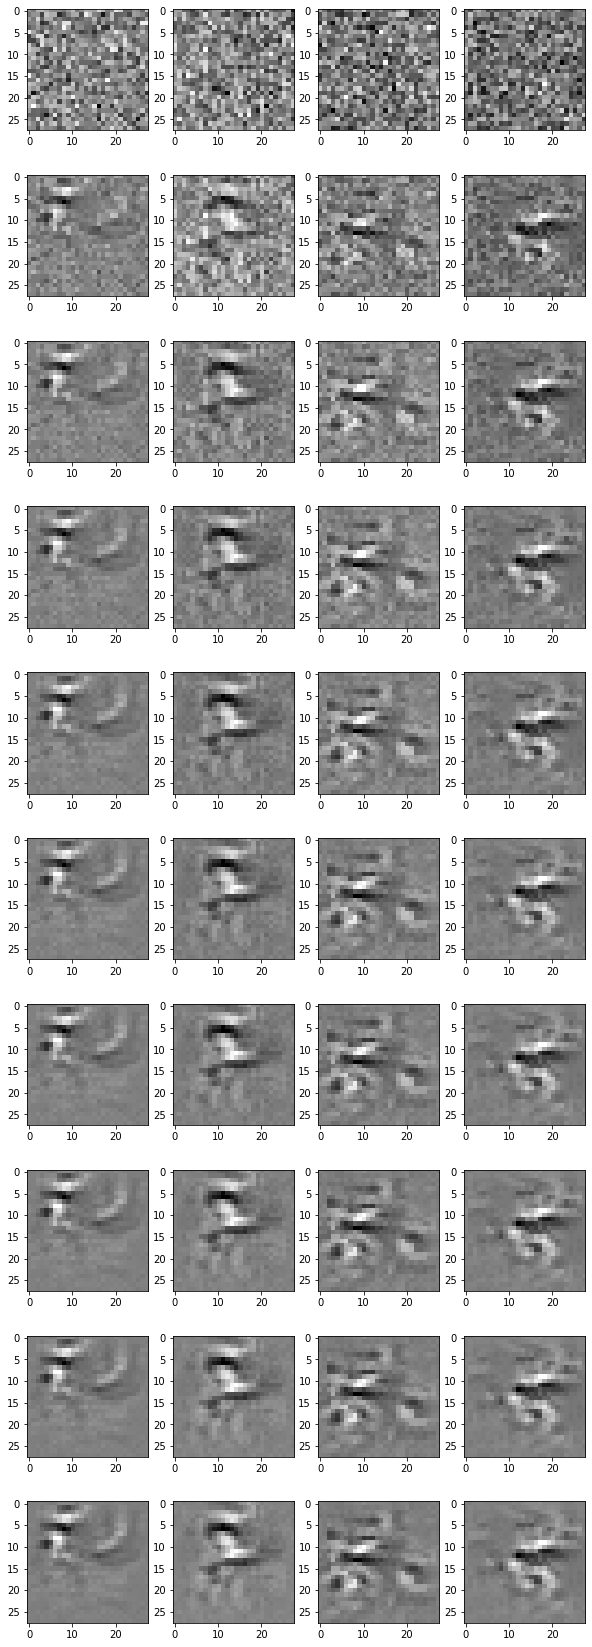

In [252]:

freeze_model(cnn_model)
dummy_input = torch.randn(784*4)
dummy_input = dummy_input.view(4,1,28,28)
dummy_input.requires_grad=True

selected_mid_neuron_id = 5
plt.figure(figsize=(10,30))
dummy_optimizer = torch.optim.SGD([dummy_input], lr=0.5)
for i in range(500):
#   mid_output = cnn_model.layers(dummy_input)
  mid_output = cnn_model(dummy_input)
  loss = -mid_output[:,selected_mid_neuron_id].mean()
  loss.backward()
#   dummy_input.data -= dummy_input.grad * 0.8
#   dummy_input.grad = None
  dummy_optimizer.step()
  dummy_optimizer.zero_grad()
  if i % 50 == 0:
    for j in range(4):
      plt.subplot(10, 4, (i//50)*4+1+j)
      plt.imshow(torch.Tensor(dummy_input[j]).detach().view(28,28), cmap='gray')

### Transpose_invariant

In [255]:
test_batch = next(iter(valid_loader))

In [256]:
test_img = test_batch[0]
shifted_example = torch.zeros_like(test_img)
shifted_example[:,:,1:] = test_img[:,:,:-1,:]

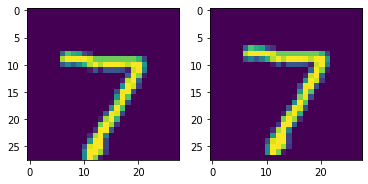

In [259]:
plt.subplot(1,2,1)
plt.imshow(shifted_example[0][0])
plt.subplot(1,2,2)
plt.imshow(test_img[0][0])

In [266]:
device = 'cuda'
model = model.to(device)
cnn_model = cnn_model.to(device)
for batch in valid_loader:
  img, label = batch
  img = img.to(device)
  shifted_example = torch.zeros_like(img)
  shifted_example[:,:,2:] = img[:,:,:-2,:]
  
  fcn_pred = model(shifted_example)
  cnn_pred = cnn_model(shifted_example)
  
  fcn_acc = get_accuracy(fcn_pred, label.to(device))
  cnn_acc = get_accuracy(cnn_pred, label.to(device))
  
  org_pred = model(img)
  org_cnn_pred = cnn_model(img)
  
  org_fcn_acc = get_accuracy(org_pred, label.to(device))
  org_cnn_acc = get_accuracy(org_cnn_pred, label.to(device))
  
  print(fcn_acc, cnn_acc, org_fcn_acc, org_cnn_acc)

0.74609375 0.94921875 0.970703125 0.98828125
0.734375 0.94921875 0.966796875 0.974609375
0.693359375 0.947265625 0.953125 0.982421875
0.740234375 0.955078125 0.955078125 0.982421875
0.744140625 0.931640625 0.953125 0.98046875
0.734375 0.97265625 0.97265625 0.9921875
0.73828125 0.958984375 0.970703125 0.990234375
0.7265625 0.94921875 0.94921875 0.990234375
0.70703125 0.94140625 0.955078125 0.98828125
0.732421875 0.951171875 0.97265625 0.978515625
0.78515625 0.978515625 0.990234375 0.998046875
0.75390625 0.98046875 0.970703125 0.98828125
0.783203125 0.958984375 0.962890625 0.986328125
0.73046875 0.998046875 0.98828125 0.998046875
0.740234375 0.974609375 0.98828125 0.990234375
0.7578125 0.98828125 0.984375 0.99609375
0.7421875 0.990234375 0.990234375 0.998046875
0.763671875 0.990234375 0.990234375 0.99609375
0.70703125 0.966796875 0.98046875 0.9921875
0.5367646813392639 0.9522058963775635 0.9632353186607361 0.9852941036224365
